In [1]:
import kagglehub
smaranjitghose_corn_or_maize_leaf_disease_dataset_path = kagglehub.dataset_download('smaranjitghose/corn-or-maize-leaf-disease-dataset')

print('Data source import complete.')


100%|██████████| 161M/161M [00:08<00:00, 20.3MB/s]

Extracting files...


Data source import complete.


# 1. Import Packages

In [5]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# 2. Create Datadrame with images

In [9]:
data_path = "/kaggle/input/corn-or-maize-leaf-disease-dataset/data"

images = []
labels = []

for subfolder in os.listdir(data_path):

    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)

        labels.append(subfolder)

data = pd.DataFrame({'image': images, 'label': labels})

# 3. Data Visualization

In [10]:
data.head()


,image,label
0,/kaggle/input/corn-or-maize-leaf-disease-datas...,Common_Rust
1,/kaggle/input/corn-or-maize-leaf-disease-datas...,Common_Rust
2,/kaggle/input/corn-or-maize-leaf-disease-datas...,Common_Rust
3,/kaggle/input/corn-or-maize-leaf-disease-datas...,Common_Rust
4,/kaggle/input/corn-or-maize-leaf-disease-datas...,Common_Rust


In [11]:
data.shape


(4188, 2)

In [12]:
strat = data['label']
train_df, dummy_df = train_test_split(data,  train_size= 0.81, shuffle= True, random_state= 123, stratify= strat)

strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [13]:
print("Training set shape:", train_df.shape)
print("Validation set shape:", valid_df.shape)
print("Test set shape:", test_df.shape)

Training set shape: (3392, 2)
Validation set shape: (398, 2)
Test set shape: (398, 2)


In [14]:
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 3392 validated image filenames belonging to 4 classes.
Found 398 validated image filenames belonging to 4 classes.
Found 398 validated image filenames belonging to 4 classes.


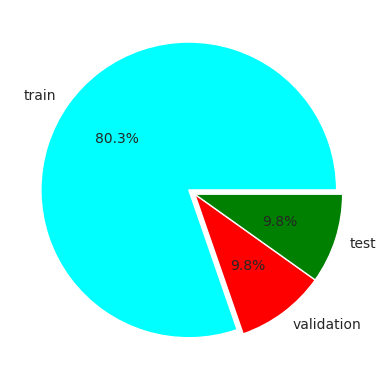

<Figure size 640x480 with 0 Axes>

In [15]:
plt.pie([len(train_gen), len(valid_gen), len(test_gen)],
        labels=['train', 'validation', 'test'], autopct='%.1f%%', colors=['aqua', 'red', 'green'], explode=(0.05, 0, 0))
plt.show()
plt.savefig('dataset_pie.png')

In [16]:
print(train_gen.class_indices)
print(test_gen.class_indices)
print(valid_gen.class_indices)

{'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}
{'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}
{'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}


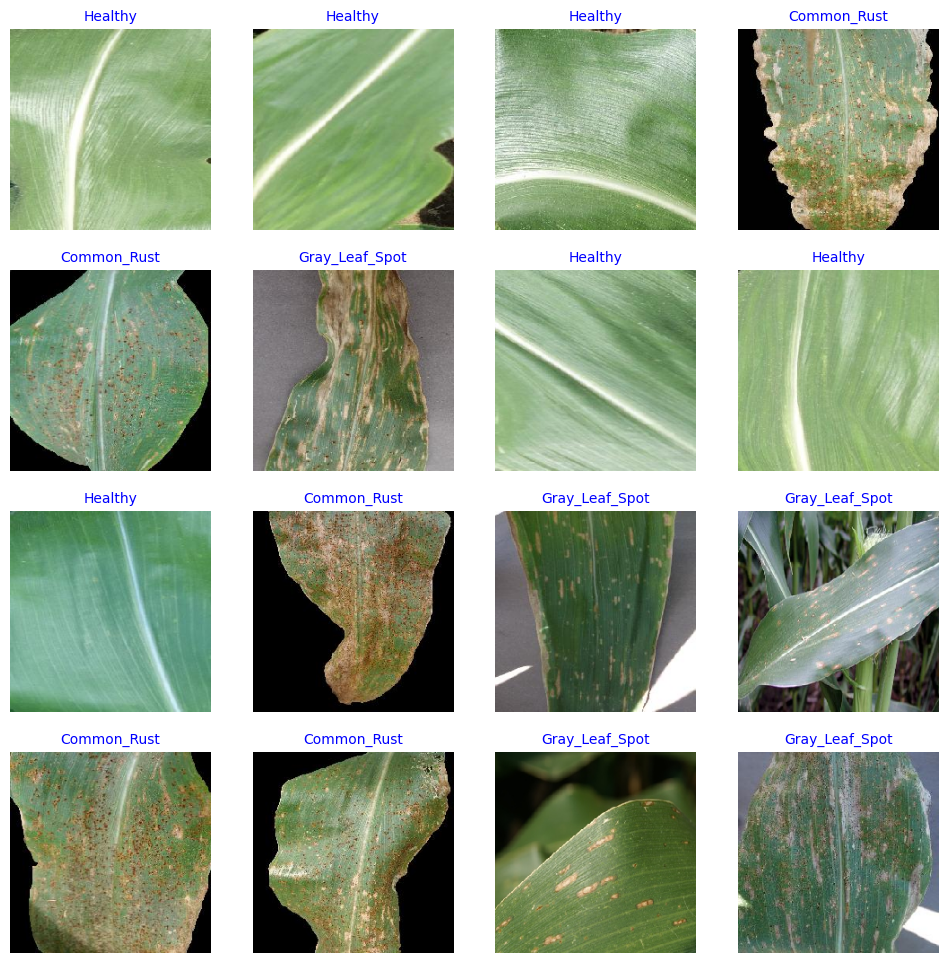

In [17]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (12, 12))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'blue', fontsize= 10)
    plt.axis('off')
plt.show()

# 4. CNN Model

In [18]:
model = Sequential()

model.add(tf.keras.layers.InputLayer(input_shape=(224, 224, 3)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())


model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())


model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dropout(0.3))

model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))


model.add(Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))



model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 110, 110, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 53, 53, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 51, 51, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 49, 49, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 22, 22, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 20, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 430,212 (1.64 MB)

 Trainable params: 429,572 (1.64 MB)

 Non-trainable params: 640 (2.50 KB)

# 5. Callback and Model Compile

In [27]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.98):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_gen,
    epochs=10,
    batch_size=32,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[callbacks]
)


Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 36s 207ms/step - accuracy: 0.8586 - loss: 0.4109 - val_accuracy: 0.6910 - val_loss: 0.7627
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 20s 191ms/step - accuracy: 0.9083 - loss: 0.2753 - val_accuracy: 0.8844 - val_loss: 0.3356
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 20s 190ms/step - accuracy: 0.9181 - loss: 0.2406 - val_accuracy: 0.9020 - val_loss: 0.2408
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 20s 186ms/step - accuracy: 0.9105 - loss: 0.2678 - val_accuracy: 0.8291 - val_loss: 0.5040
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 20s 191ms/step - accuracy: 0.9261 - loss: 0.2119 - val_accuracy: 0.8844 - val_loss: 0.3300
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 22s 204ms/step - accuracy: 0.9225 - loss: 0.2212 - val_accuracy: 0.7688 - val_loss: 0.6138
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 20s 189ms/step - accuracy: 0.9265 - loss: 0.2098 - val_accuracy: 0.9121 - val_loss: 0.2447
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 21s 190ms/step - accuracy: 0.9399 - loss: 0

# 6. Accuracy and Loss Curve

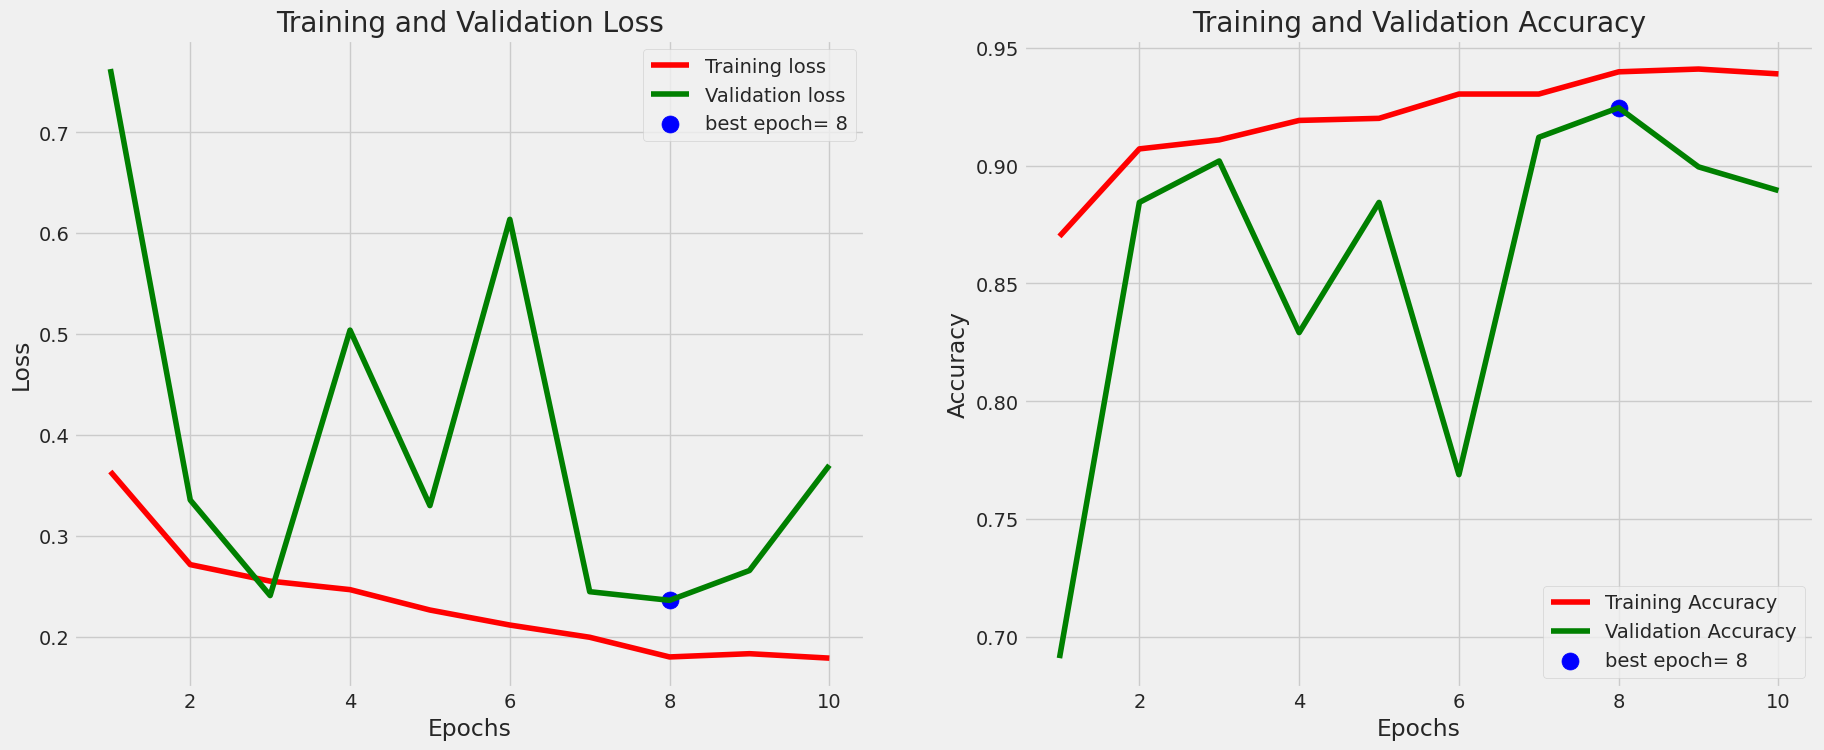

In [28]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# 7. Accuracy Score

In [29]:
loss, accuracy = model.evaluate(valid_gen)
print("Accuracy score:", accuracy)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.8994 - loss: 0.3393 
Accuracy score: 0.8894472122192383


In [30]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

199/199 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.9137 - loss: 0.2767 
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8903 - loss: 0.3664  
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8862 - loss: 0.3709  
Train Loss:  0.2821487486362457
Train Accuracy:  0.9139150977134705
--------------------
Valid Loss:  0.3700578808784485
Valid Accuracy:  0.8894472122192383
--------------------
Test Loss:  0.36825570464134216
Test Accuracy:  0.8869346976280212


# 8. Classification Report

In [31]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step


In [33]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))


                precision    recall  f1-score   support

        Blight       0.88      0.82      0.85       109
   Common_Rust       0.97      0.94      0.95       124
Gray_Leaf_Spot       0.69      0.69      0.69        54
       Healthy       0.90      1.00      0.95       111

      accuracy                           0.89       398
     macro avg       0.86      0.86      0.86       398
  weighted avg       0.89      0.89      0.89       398



# 9. Confusion Matrix

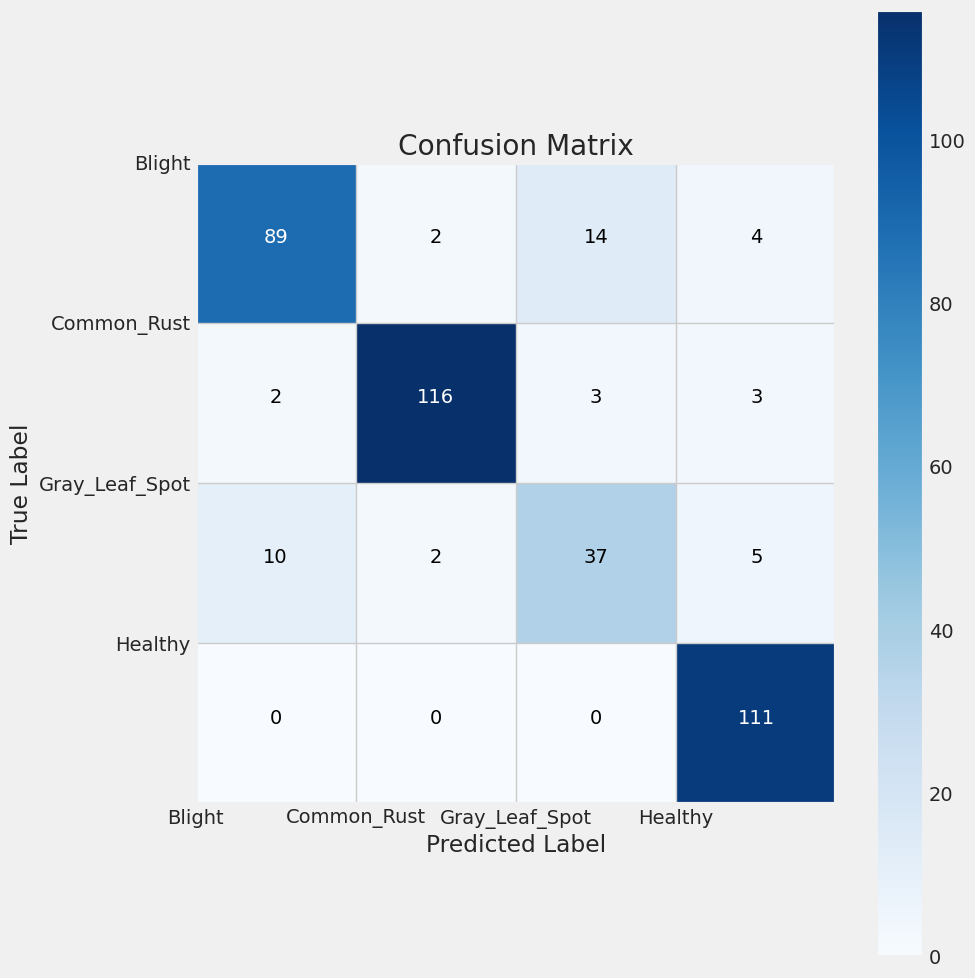

In [34]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks - 0.5, classes)
plt.yticks(tick_marks - 0.5, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

# 10. Model Save

In [35]:
model.save('model2.h5')
